<a href="https://colab.research.google.com/github/bmt2158/dockerfile-ns3.32/blob/main/Ginibre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import sys as _sys
import numpy as np
import numba as _nb
from numba import jit
from scipy import special as _special
from scipy import optimize as _optimize

from random import randrange, choice
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

import tempfile
import itertools

# Main Sampling functions
def sample_indices(kernel, R, epsilon=2**-53):
    I = []
    Lambda = 1
    i = 0
    R2 = R**2
    while Lambda > epsilon:
        Lambda = kernel.F(i, R2)
        if np.random.binomial(1, Lambda) == 1:
            I.append(i)
        i += 1
    return np.array(I, dtype='int64')

def sample_module(C, R, I, invLambdas, F, epsilon):
    i = np.random.multinomial(1, C).argmax()
    c = np.random.uniform()
    f = lambda r: F(I[i], r**2)*invLambdas[i] - c
    r = _optimize.brentq(f, 0, R, xtol=epsilon)
    return r

def sample_argument(V, r, I, invLambdas, g, epsilon):
    G = g(I,r)*np.sqrt(invLambdas)
    l, u = _argtruncate(G, epsilon)
    p = np.zeros(I[u-1] - I[l] + 1, dtype='complex128')
    _instantiate_polynomial(p, I, V, G, l, u)
    p[1:] /= 0.5*p[0]*1j*np.arange(1, p.size)
    p[0] = -np.sum(p[1:])
    n = np.arange(p.size)
    c = np.random.uniform()
    f = lambda alpha: alpha + np.real(_horner(p, np.exp(1j*alpha))) - c*2*np.pi
    alpha = _optimize.brentq(f, 0, 2*np.pi, xtol=epsilon)
    return alpha

def sample_points(kernel, R, I, epsilon=2**-53, print_point=lambda x,y,i:None):
    global points_list
    F, g = kernel
    n = len(I)
    W = np.zeros(n, dtype='complex128')
    U = np.ones(n, dtype='float64')
    V = np.identity(n, dtype='complex128')
    Lambdas = np.array([F(i, R**2) for i in I])
    invLambdas = 1/Lambdas
    for i in range(n, 0, -1):
        # Draw point Wi
        r = sample_module(U/U.sum(), R, I, invLambdas, F, epsilon)
        alpha = sample_argument(V, r, I, invLambdas, g, epsilon)
        p = r*np.exp(1j*alpha)
        W[n-i] = p
        px = p.real
        py = p.imag
        print_point(px, py, n-i)

        # Compute new vector ei
        phi = g(I,r)*np.exp(1j*alpha*I)*np.sqrt(invLambdas)
        l, u = _argtruncate(phi, epsilon)
        phi = V[:, l:u].dot(phi[l:u])
        e = phi/np.linalg.norm(phi)

        # Update arrays U and V
        U -= e.real**2 + e.imag**2
        U[U<0] = 0
        _V_minus_e_estar(V, e, epsilon)
    return V, W

# Kernels

from collections import namedtuple as _namedtuple
Kernel = _namedtuple('Kernel', ['F','g'])

kernels = {
    # Ginibre point process
    'ginibre': Kernel(lambda i, r: _special.gammainc(i+1,r),
                      lambda i, r: np.where(i!=0, np.exp(i*np.log(r) - 0.5*(_special.gammaln(i+1) + r**2)),
                                                   np.exp(-0.5*r**2))),

    # Zeros of an analytic function with Gaussian coefficients
    'gaussian': Kernel(lambda i, r: np.power(r,i+1),
                       lambda i, r: np.power(r,i)*np.sqrt(i+1)),

    ## Experimental kernels
    # Gaussian kernel times 1 - r**2
    'weighted': Kernel(lambda i, r: 3*(np.power(r,i+1) - 2*np.power(r, i+2)*(i+1)/(i+2) + np.power(r, i+3)*(i+1)/(i+3)),
                       lambda i, r: np.power(r,i)*np.sqrt(i+1)),

    # Uniform modules
    'pseudo-uniform': Kernel(lambda i, r: r,
                             lambda i, r: 1),
}

# Parser  for command line arguments

if __name__ == '__main__':

    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    parser.add_argument('-R', type=float, help="radius", default=1.)

    parser.add_argument('-N', metavar='N', type=int,
                        help="preset N points by truncating the kernel to the N first eigenfunctions",
                        default=None)

    parser.add_argument('-k', '--kernel', metavar='kernel', type=str, help='kernel to sample : ginibre or gaussian',
                        default='ginibre')

    parser.add_argument('-p', '--precision', metavar='prec  ', type=float, help="error tolerated for internal computations",
                        default=2**-53)

    parser.add_argument('-s', '--size', metavar='size  ', type=float, help="points size in pixels", default=5)

    parser.add_argument('-t', '--time', metavar='time  ', type=int, help="refresh time in miliseconds", default=100)

    parser.add_argument('-o', '--output', metavar='output', type=str,
                        help='name of file to output the data, implies --nogui', default=None)

    parser.add_argument('-e ', '--error', action='store_true',
                        help="compute the error and the condition number for the result", default=False)

    parser.add_argument('-pg', '--profile', action='store_true', help="output time indicator some functions", default=False)

    parser.add_argument('-q ', '--quiet', action='store_true', help="disable information messages on standard output",
                        default=False)

    parser.add_argument('--nogui', action='store_true', help="output points coordinate on the terminal", default=False)

    args, unknown = parser.parse_known_args()

    if not args.quiet:
        print("Importing libraries ...")


# Util functions compiled with numba

if __name__ == '__main__':
    if not args.quiet:
        print("Compiling functions ...")


# Critical loops compiled

@jit(nopython=True)
# @_nb.njit((_nb.complex128[::1], _nb.int64[::1], _nb.complex128[:,::1], _nb.float64[::1], _nb.int64, _nb.int64))

def _instantiate_polynomial(p, I, M, G, l, u):
    for i in range(l, u):
        for j in range(i, u):
            p[I[j]-I[i]] += M[i,j]*G[i]*G[j]

@_nb.njit((_nb.complex128[:,::1], _nb.complex128[::1], _nb.complex128[::1]))
def _fused_minus_outer(V, e, f):
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V[i,j] -= e[i]*f[j]

@_nb.guvectorize([(_nb.complex128[::1], _nb.complex128, _nb.complex128[::1], _nb.complex128[::1])],
                '(n),(),(n)->(n)')
def _fused_minus_outer_vec(v, c, f, res):
        for j in range(res.shape[0]):
            res[j] = v[j] - c*f[j]

def _V_minus_e_estar(V, e, epsilon):
        l, u = _argtruncate(e, epsilon)
        f = e.conjugate()
        if u-l > 0.9*len(e):
            _fused_minus_outer(V, e, f)
        else:
            _fused_minus_outer_vec(V[l:u, l:u], e[l:u], f[l:u], out=V[l:u, l:u])

@_nb.njit((_nb.complex128[::1], _nb.complex128))
def _horner(p, v):
    c = p[-1]
    for i in range(len(p)-2, -1, -1):
        c = c*v + p[i]
    return c

def _argtruncate(v, epsilon):
    vbig = abs(v) > epsilon
    l = np.argmax(vbig)
    u = len(vbig) - np.argmax(vbig[::-1])
    return l, u

# Qt interface functions

def _init_figure(R, size):
    global _scatter, _view, _spot, _app
    # Launch app
    pg.setConfigOptions(background = 'w', foreground = 'k')
    _app = pg.mkQApp()

    # Create the main view
    _view = pg.PlotWidget()
    _view.setRenderHint(pg.Qt.QtGui.QPainter.HighQualityAntialiasing)
    _view.resize(800, 600)
    _view.setRange(xRange=(-R,R), yRange=(-R,R))
    _view.setWindowTitle('Determinantal point process')
    _view.setTitle('Sampling the number of points ...')
    _view.setAspectLocked(True)
    _view.show()

    # Create the circle and add it to the view
    circle = pg.Qt.QtWidgets.QGraphicsEllipseItem()
    circle.setRect(-R, -R, 2*R, 2*R)
    circle.setPen(pg.mkPen(width=2, color='k'))
    _view.addItem(circle)

    # Create the scatter plot and add it to the view
    _scatter = pg.ScatterPlotItem(symbol='o')
    _scatter.setSize(size)
    _view.addItem(_scatter)

    # Spot
    _spot = np.empty(1, dtype=_scatter.data.dtype)
    _spot['pen'] = pg.mkPen(width=1, color='b')
    _spot['brush'] = pg.mkBrush(None)
    _spot['size'] = size
    _spot['visible'] = True
    if pg.Qt.QT_LIB not in ['PySide2', 'PySide6']:
        _spot['targetQRectValid'] = False
    _scatter.updateSpots(_spot)

    _app.processEvents()

def _update_figure():
    global _scatter, _view, _Npoints
    pad =  len(str(_Npoints))
    _view.setTitle('<pre>Sampling: {0: >{2}}/{1} points</pre>'.format(_scatter.data.size, _Npoints, pad))
    _scatter.prepareGeometryChange()
    _scatter.bounds = [None, None]

def _print_point_qt(px, py, i):
    _scatter.data.resize(i+1, refcheck=False)
    _scatter.data[i] = _spot
    if pg.Qt.QT_LIB not in ['PySide2', 'PySide6']:
        _scatter.data[i]['targetQRect'] = pg.Qt.QtCore.QRectF()
    _scatter.data[i]['x'] = px
    _scatter.data[i]['y'] = py
    _app.processEvents()

def qt_sample(R, N = None, kernel=kernels['ginibre'], precision=2**-53, size=5, refresh=100, error=False, quiet=False):
    global _Npoints, pg
    import pyqtgraph as pg
    if N is not None and kernel.F(N-1, R**2) == 0:
        raise ValueError("N is too big")
    _init_figure(R, size)
    if N is None:
        I = sample_indices(kernel, R, precision)
    else:
        I = np.arange(N)
    _Npoints = len(I)
    timer = pg.Qt.QtCore.QTimer()
    timer.timeout.connect(_update_figure)
    timer.start(refresh)
    V, W = sample_points(kernel, R, I, precision, _print_point_qt)
    timer.stop()
    _update_figure()
    _app.processEvents()
    if error:
        _view.setTitle('Computing the error and the condition number ...')
        _app.processEvents()
        Error = np.linalg.norm(V)
        tI = I.reshape(-1,1)
        M = kernel.g(tI, np.abs(W))*np.exp(1j*np.angle(W)*tI)/np.sqrt(kernel.F(tI, R**2))
        ConditionNumber = np.linalg.cond(M)
        _view.setTitle('<pre>Number of points: {0}        Error: {1:.3e}        Condition number: {2:.3e}</pre>'
                      .format(_Npoints, Error, ConditionNumber))
    else:
        _view.setTitle('<pre>Number of points: {0}</pre>'.format(_Npoints))
    Blue = pg.mkBrush('b')
    _scatter.setBrush([Blue]*len(_scatter.data))
    _app.exec_()

# Text interface functions

def _build_print_point(output, quiet, n):
    pad =  len(str(n))
    message = '\r{{0: >{0}}}/{1} '.format(pad, n)
    if output is None and quiet:
        print_point_txt = lambda x, y, i: None
    elif output is None and not quiet:
        print_point_txt = lambda x, y, i: _sys.stdout.write(message.format(i+1))
    elif output is not None and quiet:
        print_point_txt = lambda x, y, i: output.write("{0} {1}\n".format(x, y))
    else:
        print_point_txt = lambda x, y, i: _sys.stdout.write(message.format(i+1)) and output.write("{0} {1}\n".format(x, y))
    return print_point_txt

def sample(R, N = None, kernel=kernels['ginibre'], precision=2**-53, error=False, quiet=False, output=None):
    if N is None:
        if not quiet:
            print('Sampling the number of points ...')
        I = sample_indices(kernel, R, precision)
    else:
        if kernel.F(N-1, R**2) == 0:
            raise ValueError("N is too big")
        I = np.arange(N)
    print_point_txt = _build_print_point(output, quiet, len(I))
    if not quiet:
        print('Sampling the points ...')
    V, W = sample_points(kernel, R, I, precision, print_point_txt)
    if not quiet:
        print()
    if error:
        if not quiet:
            print('Computing the error and the condition number ...')
        Error = np.linalg.norm(V)
        tI = I.reshape(-1,1)
        M = kernel.g(tI, np.abs(W))*np.exp(1j*np.angle(W)*tI)/np.sqrt(kernel.F(tI, R**2))
        ConditionNumber = np.linalg.cond(M)
        if not quiet:
            print('Error: {0:.3e}'.format(Error))
            print('Condition number: {0:.3e}'.format(ConditionNumber))
        if output is not None:
            output.write('# Error: {0:.3e}\n'.format(Error))
            output.write('# Condition number: {0:.3e}\n'.format(ConditionNumber))
        return W, Error, ConditionNumber
    else:
        return W

# Main script if called from command line


if __name__ == '__main__':
    if args.profile:
        import line_profiler as lp
        import atexit
        profile = lp.LineProfiler()
        sample_points = profile(sample_points)
        sample_argument = profile(sample_argument)
        atexit.register(profile.print_stats)
    if args.nogui or args.output is not None:
        if args.output is None:
            output = _sys.stdout
        else:
            output = open(args.output, 'w')
        sample(args.R, args.N, kernels[args.kernel], args.precision, args.error, args.quiet, output)
        if args.output is not None:
            output.close()


Importing libraries ...
Compiling functions ...


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import bernoulli
from scipy.spatial import Voronoi, ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 11,}

In [ ]:
def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0], towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1], towers[:, 1] <= bounding_box[3]))


def voronoi(towers, bounding_box, N):
    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left, points_right, axis=0),
                                 np.append(points_down, points_up, axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = Voronoi(points)
    vor.filtered_points = points_center
    vor.filtered_regions = [vor.regions[vor.point_region[i]] for i in range(len(points_center))]
    return vor

def central_area_perim(vor):
    return ConvexHull(vor.vertices[vor.filtered_regions[0], :]).volume, ConvexHull(vor.vertices[vor.filtered_regions[0], :]).area

def area_perim(vor):
    area, perimeter = [], []
    for i in range(5):
        if len(vor.filtered_regions) >= i:
            area.append(ConvexHull(vor.vertices[vor.filtered_regions[i], :]).volume)
            perimeter.append(ConvexHull(vor.vertices[vor.filtered_regions[i], :]).area)
        else:
            area.append(np.mean(area))
            perimeter.append(np.mean(perimeter))
    return area, perimeter

def ginibre(N, cells):
    radius = (np.sqrt(N)) ; precision = 2**-53 ; error = False ; quiet=True ; output=None
    args = [radius, N, kernels['ginibre'], precision, error, quiet, output]

    sample_ginibre = sample(*args)
    X_ginibre, Y_ginibre = sample_ginibre.real, sample_ginibre.imag

    ginibre_points = np.array([X_ginibre, Y_ginibre]).T
    indices = np.argsort((ginibre_points[:,0])**2 + ((ginibre_points[:,1])**2))
    ginibre_points = ginibre_points[indices]
    ginibre_vor = voronoi(ginibre_points, (-np.sqrt(N)-.1, np.sqrt(N)+.1, -np.sqrt(N)-.1, np.sqrt(N)+.1), len(ginibre_points))

    if cells==1:
        vor_area, vor_perim = central_area_perim(ginibre_vor)
    else:
        vor_area, vor_perim = area_perim(ginibre_vor)

    return vor_area, vor_perim

def beta_ginibre(N, beta, cells):
    radius = (np.sqrt(N)) ; precision = 2**-53 ; error = False ; quiet=True ; output=None
    args = [radius, N, kernels['ginibre'], precision, error, quiet, output]

    sample_init = sample(*args)
    sample_beta_ginibre = sample_init*(bernoulli.rvs(beta, size=N))
    sample_beta_ginibre = np.array([a for a in sample_beta_ginibre if a != 0])*(np.sqrt(beta))
    X_beta_ginibre, Y_beta_ginibre = sample_beta_ginibre.real, sample_beta_ginibre.imag

    beta_ginibre_points = np.array([X_beta_ginibre, Y_beta_ginibre]).T
    indices = np.argsort((beta_ginibre_points[:,0])**2 + ((beta_ginibre_points[:,1])**2))
    beta_ginibre_points = beta_ginibre_points[indices]

    beta_ginibre_vor = voronoi(beta_ginibre_points,
                               (-np.sqrt(N*beta)-.1, np.sqrt(N*beta)+.1, -np.sqrt(N*beta)-.1, np.sqrt(N*beta)+.1),
                               len(beta_ginibre_points))

    if cells==1:
        vor_area, vor_perim = central_area_perim(beta_ginibre_vor)
    else:
        vor_area, vor_perim = area_perim(beta_ginibre_vor)

    return vor_area, vor_perim

def poisson(N, cells):
    radius = np.sqrt(N)
    alpha = 2 * np.pi * scipy.stats.uniform.rvs(0,1,N)
    r = radius * np.sqrt(scipy.stats.uniform.rvs(0,1,N))

    X_poisson, Y_poisson = r*np.cos(alpha), r*np.sin(alpha)
    poisson_points = np.array([X_poisson, Y_poisson]).T

    indices = np.argsort((poisson_points[:,0])**2 + ((poisson_points[:,1])**2))
    poisson_points = poisson_points[indices]
    poisson_vor = voronoi(poisson_points, (-radius -.1, radius +.1, -radius -.1, radius +.1), len(poisson_points))

    if cells==1:
        vor_area, vor_perim = central_area_perim(poisson_vor)
    else:
        vor_area, vor_perim = area_perim(poisson_vor)

    return vor_area, vor_perim

def ratio_ginibre(N, cells):
    G = ginibre(N, cells)
    return np.mean(4*np.pi*np.array(G)[0]/(np.array(G)[1])**2)

def ratio_beta_ginibre(N, beta, cells):
    beta_G = beta_ginibre(N, beta, cells)
    return np.mean(4*np.pi*np.array(beta_G)[0]/(np.array(beta_G)[1])**2)

def ratio_poisson(N, cells):
    P = poisson(N, cells)
    return np.mean(4*np.pi*np.array(P)[0]/(np.array(P)[1])**2)


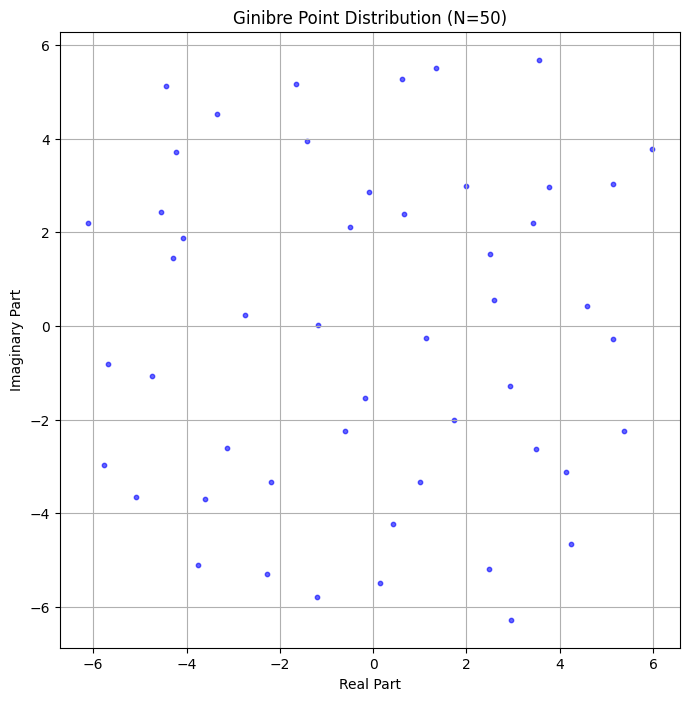

In [ ]:
#Ginibre点を生成し、可視化する

import matplotlib.pyplot as plt
import numpy as np

def visualize_ginibre(N):
    # Ginibre点を生成
    radius = np.sqrt(N)
    precision = 2**-53
    error = False
    quiet = True
    output = None
    args = [radius, N, kernels['ginibre'], precision, error, quiet, output]

    sample_ginibre = sample(*args)
    X_ginibre, Y_ginibre = sample_ginibre.real, sample_ginibre.imag

    # 散布図を描画
    plt.figure(figsize=(8, 8))
    plt.scatter(X_ginibre, Y_ginibre,c='blue', s=10, alpha=0.6)
    plt.title(f"Ginibre Point Distribution (N={N})")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.axis("equal")  # アスペクト比を1:1に設定
    plt.grid(True)
    plt.show()

# 実行例
visualize_ginibre(50)

<Figure size 1000x1000 with 0 Axes>

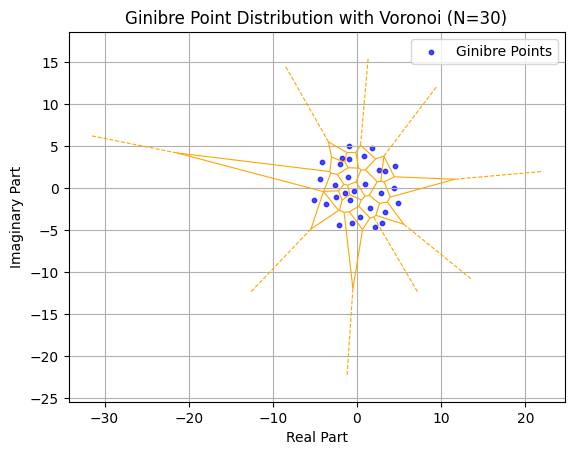

In [ ]:
#voronoi分割も可視化できるかも！？グラフの幅はNによって変えたほうがよさそう
from scipy.spatial import Voronoi, voronoi_plot_2d

def visualize_ginibre_with_voronoi(N):
    # Ginibre点を生成
    radius = np.sqrt(N)
    precision = 2**-53
    error = False
    quiet = True
    output = None
    args = [radius, N, kernels['ginibre'], precision, error, quiet, output]

    sample_ginibre = sample(*args)
    X_ginibre, Y_ginibre = sample_ginibre.real, sample_ginibre.imag

    # ボロノイ分割の計算
    points = np.column_stack((X_ginibre, Y_ginibre))
    vor = Voronoi(points)

    # ボロノイセルの描画
    plt.figure(figsize=(10, 10))
    voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=0.8, show_points=False)

    # Ginibre点の描画
    plt.scatter(X_ginibre, Y_ginibre, s=10, color="blue", alpha=0.7, label="Ginibre Points")
    plt.title(f"Ginibre Point Distribution with Voronoi (N={N})")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.axis("equal")
    plt.legend()
    plt.grid(True)
    plt.show()

# 実行例
visualize_ginibre_with_voronoi(30)